# Fitting a changing trend
We will use the time series of the log daily page views for the Wikipedia page for Peyton Manning as an example to illustrate how to fit a changing trend. 

First, we load the data:

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet

In [2]:
df = pd.read_csv('../example_data/wp_log_peyton_manning.csv')
df.head(3)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677


Now we can fit an initial model without any customizations.

We specify the data frequency to be daily. The model will remember this later when we predict into the future.

In [3]:
m = NeuralProphet()
metrics = m.fit(df, freq="D")
metrics.head(3)

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.67it/s, SmoothL1Loss=0.00612, MAE=0.387, RegLoss=0]


,SmoothL1Loss,MAE,RegLoss
0,0.300373,3.092822,0.0
1,0.038623,1.018642,0.0
2,0.011501,0.571695,0.0


The returned metrics dataframe contains recoded metrics for each training epoch.

Next, we create a dataframe to predict on. 
Here, we specify that we want to predict one year into the future and that we want to include the entire history.

In [4]:
future = m.make_future_dataframe(df, periods=365, n_historic_predictions=len(df))
future.tail(3)

,ds,y,t,y_scaled
3267,2017-01-17,NaN,1.122511,NaN
3268,2017-01-18,NaN,1.122848,NaN
3269,2017-01-19,NaN,1.123186,NaN


Note: 'y' and 'y_scaled' are not given for the period extending into the future, as we do not know their true values.

In [5]:
forecast = m.predict(future)
print(list(forecast.columns))

['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly', 'season_weekly']


The returned forecast dataframe contains the original datestamps, 'y' values, the predicted 'yhat' values, residuals and all the individual model components.

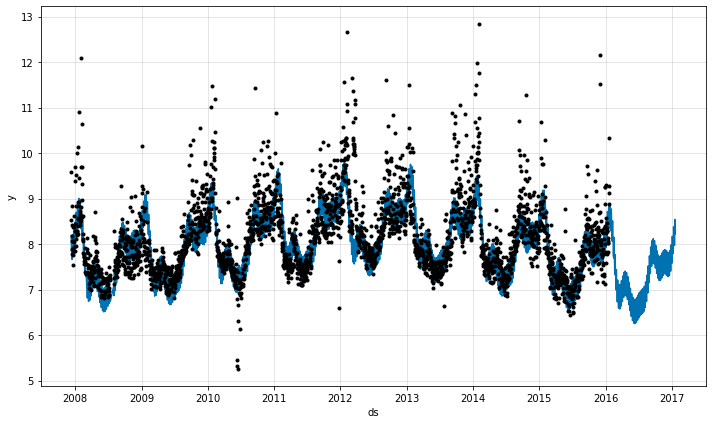

In [6]:
# plots the model predictions
fig1 = m.plot(forecast)

In [7]:
# plots the individual forecast components for the given time period.
# fig = m.plot_components(forecast, residuals=True)

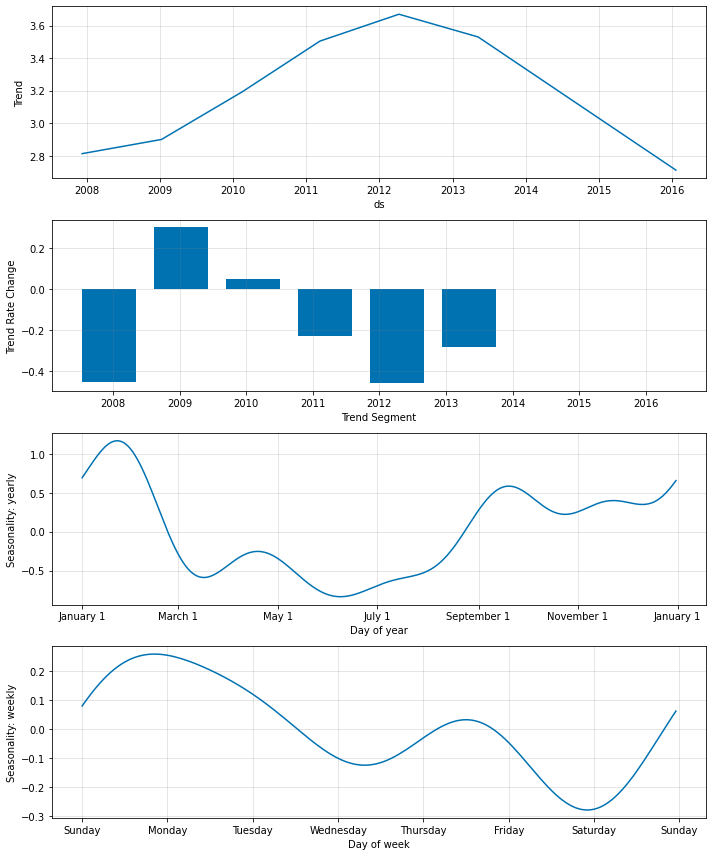

In [8]:
# visualizes the model parameters.
fig2 = m.plot_parameters()

# Adjusting Trend

The default values work fairly well in this example. However, the default of 5 changepoints may not be adequate if the actual change in trend happens to fall in a region between the points. 

## Increasing Trend Flexibility
We can address this by increasing the number of changepoints, giving the trend more flexibility, at the danger of overfitting.

Let's try what happens if we increase the number of changepoints to 30.
Additionally, we can increase the range of data on which we fit trend changepoints to only exlude the last 10 percent (default is 20 percent).

In [9]:
m = NeuralProphet(
    n_changepoints=30,
    changepoints_range=0.90,    
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s, SmoothL1Loss=0.00603, MAE=0.381, RegLoss=0]


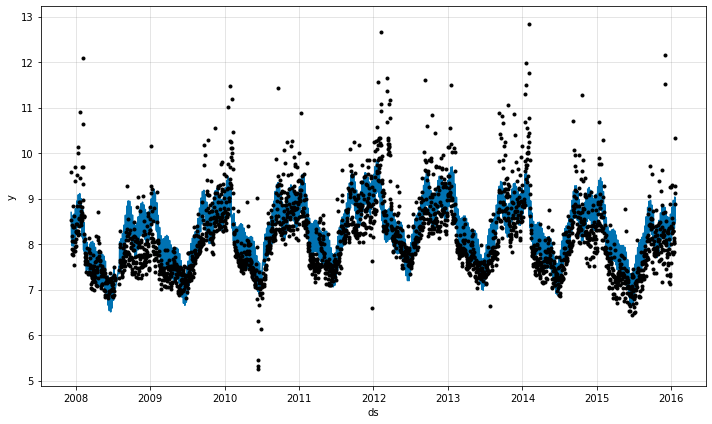

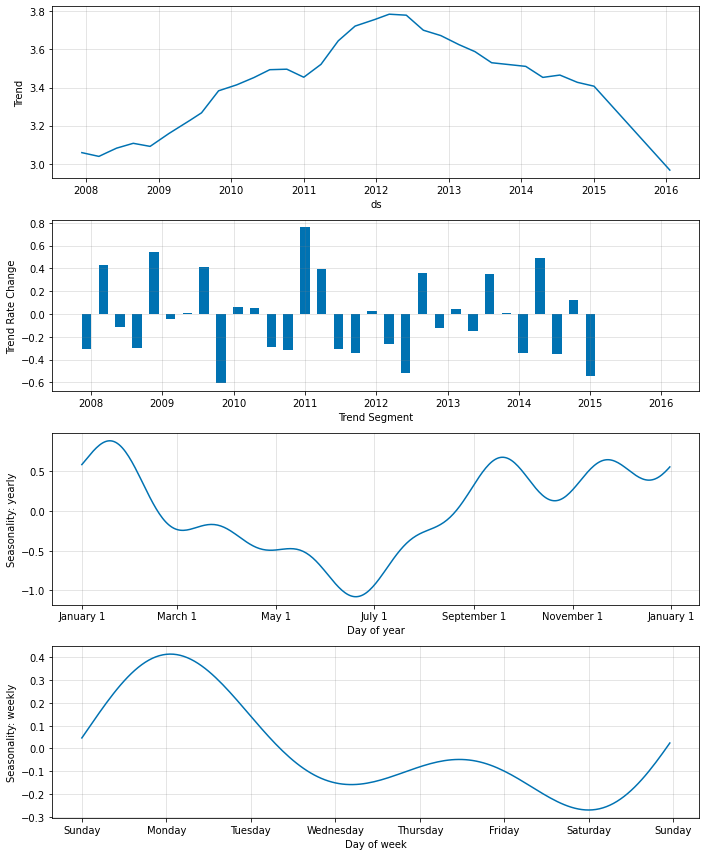

In [10]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()

Looking at the trend rate changes it becomes evident that the trend is overfitting to short-term fluctuations. 

## Automatic trendpoint selection
By adding regularization, we can achieve an automatic selection of the most relevant changepoints and draw the rate changes of other points close to zero. 


In [11]:
m = NeuralProphet(
    n_changepoints=30,
    trend_reg=1.00,
    changepoints_range=0.90,    
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.29it/s, SmoothL1Loss=0.00668, MAE=0.41, RegLoss=0.00303] 


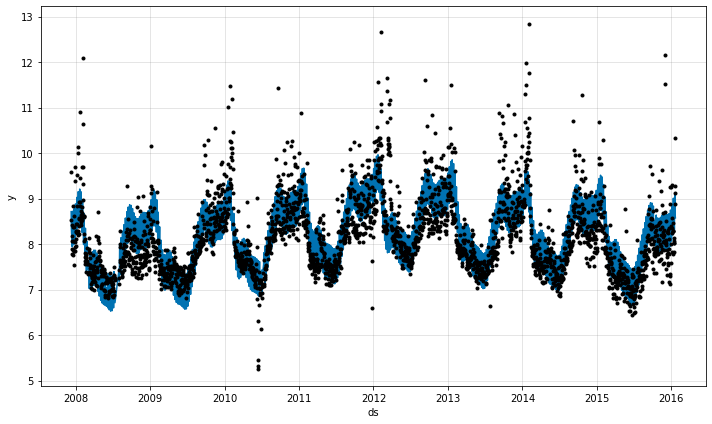

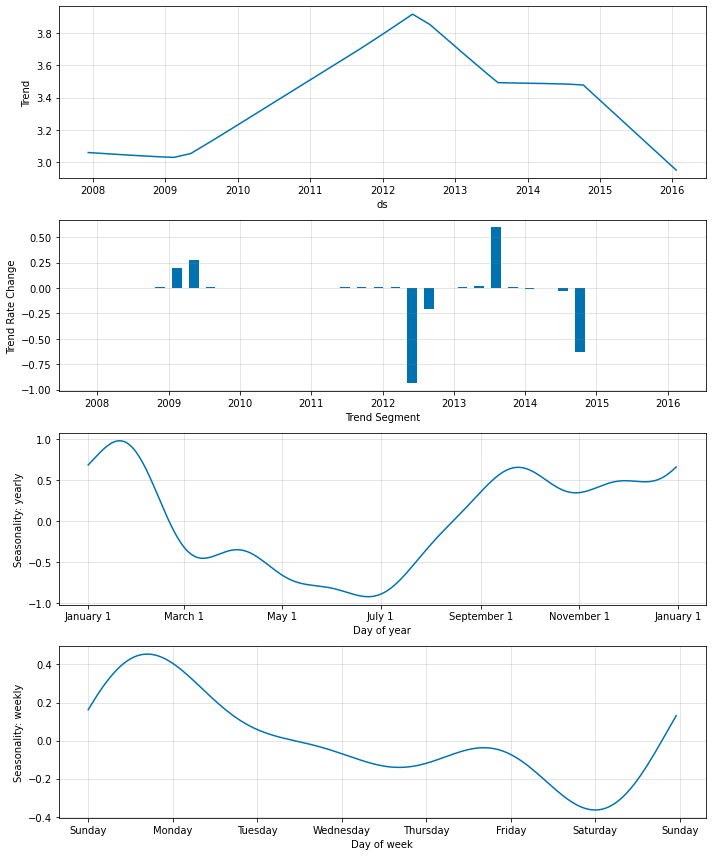

In [12]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()

Now the model selects only a few relevant trend changepoints, drawing the rest closer to zero.

## Manual Trend Changepoints
You can also manually specify the trend changepoints.

Note: A changepoint will always be added at the beginning. You can ignore it.

In [13]:
m = NeuralProphet(
    changepoints=['2012-01-01', '2014-01-01'],
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 15.32it/s, SmoothL1Loss=0.00639, MAE=0.392, RegLoss=0]


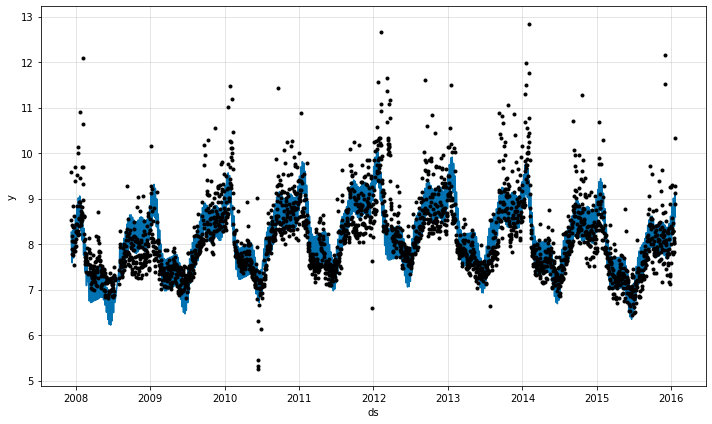

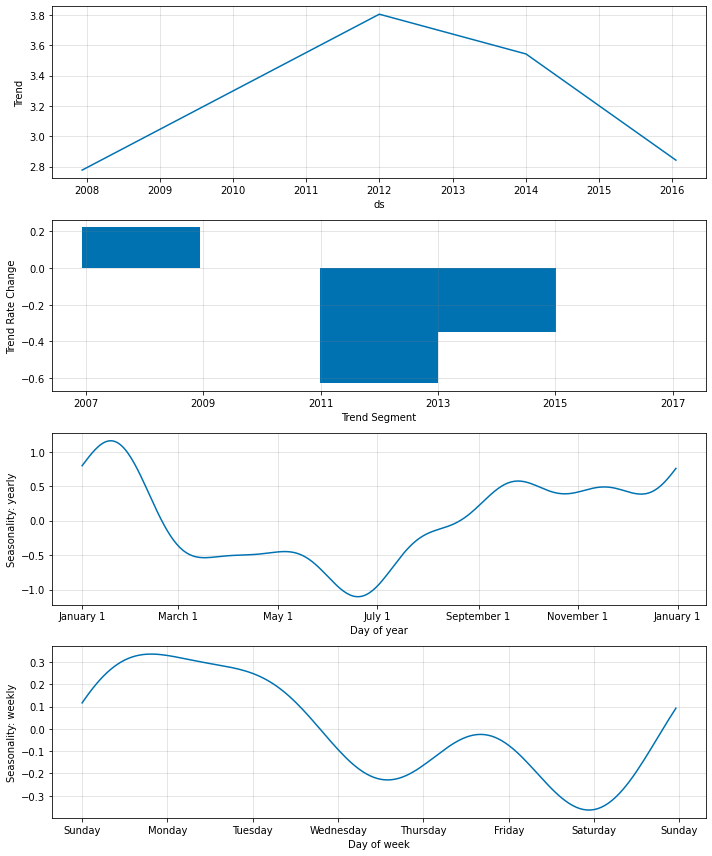

In [14]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()

## Fine-tuning Trend Flexibility
We can adjust the regularization strength to get more or less points with a non-zero rate change.

Note: for too high regularization strengths, the model fitting process becomes unstable.

In [15]:
m = NeuralProphet(
    n_changepoints=30,
    trend_reg=3.00,
    changepoints_range=0.90,   
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[40/40]: 100%|██████████| 40/40 [00:02<00:00, 14.42it/s, SmoothL1Loss=0.00637, MAE=0.393, RegLoss=0.00228]


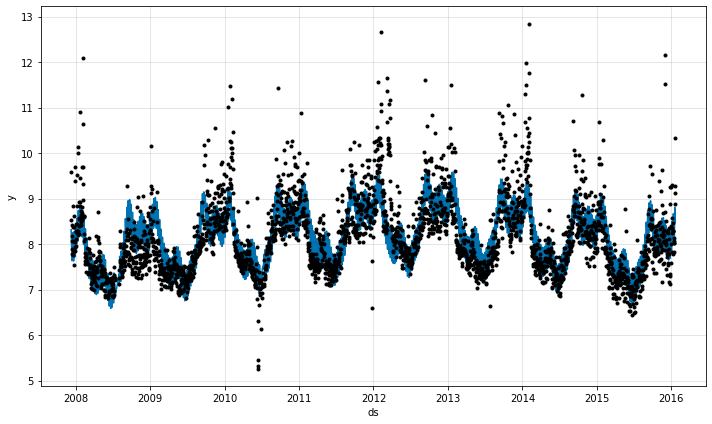

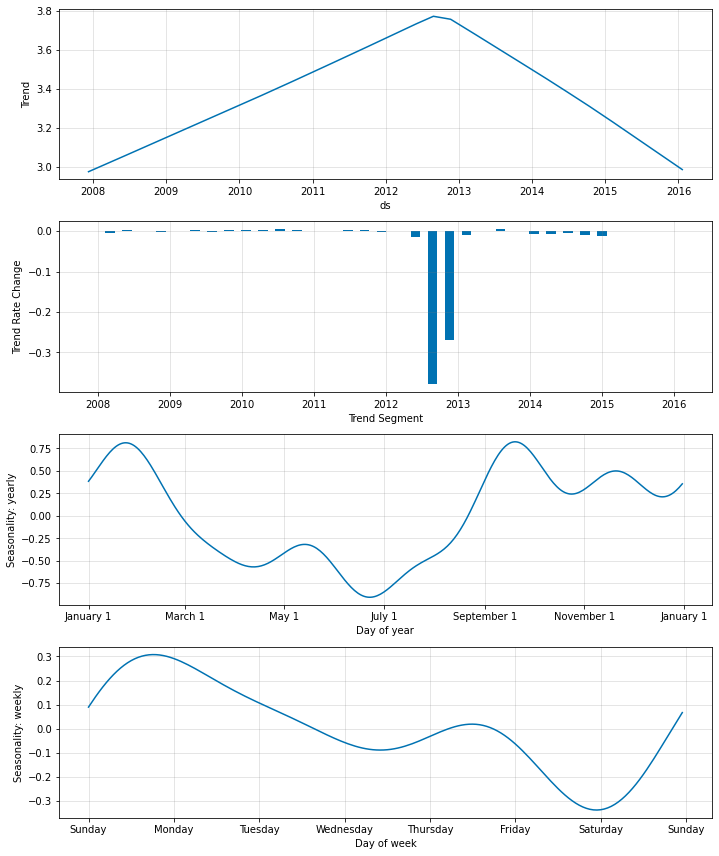

In [16]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()